# Bernoulli's Sample Size

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1g9r82f/q_required_sample_size_to_infer_which_of_two/).

> I'm looking at a Bernoulli process which may have either of two possible values of its trial probability parameter, let's call them `q1` and `q2`. I know these values beforehand, but not which of them is the right one.
> 
> I'm interested in finding out which of the two it is, but sampling from the process is quite costly (~10 real time minutes per sample), so before committing to this I would like to make a rough estimation for how many samples it will likely take to tell with reasonable confidence (let's say 95%) that the one that looks more likely in the running sample is indeed the right one. I'm aware that this required sample size will very sensitively depend on how close to each other `q1` and `q2` are.
> 
> So I suppose I'm looking for an approximation formula that relates sample size n, w.l.o.g. true probability `q1`, false probability `q2`, and required confidence level `c` (and, if that's not too much of a complication, Bayesian prior belief `b1` that `q1` is indeed true) to each other.
> 
> For actually conducting the experiment, I was just going to apply the law of total probability, using the binomial distribution's probability mass function with observed `k` and either value of `p` for the conditional probability update, sampling until either of the two model's posterior probability exceeds the required confidence level `c`. Is this a valid way to go about it or am I introducing any kind of bias this way?

There are two questions here: the first is whether we can say ahead of time what sample size we'll need to get to the desired level of confidence, `c`; the second is whether it's OK to sample until you reach `c`.
To answer the second question first, yes.

Now let's see why that's true.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/bernoulli.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

'utils.py'

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Bernoulli Trials

To put the question in a context, suppose you manufacture mechanical coin flippers that are supposed to be fair -- that is, they should flip heads or tails with equal probability.
And most of them do, but suppose 20% of the flippers have a defect that causes them to flip heads 70% of the time.
As part of the quality control process, you want to test the flippers and detect the defective ones.
How many flips does it take to be confident you have identified good and defective flippers correctly?

Here are the probabilities of flipping heads.

In [4]:
q1 = 0.5
q2 = 0.7

And here are the prior probabilities that a random flipper is good or defective.

In [5]:
b1 = 0.8
b2 = 0.2

I'll put those values in a `Pmf` object.

In [6]:
from empiricaldist import Pmf

bs = [b1, b2]
qs = [q1, q2]
prior = Pmf(bs, qs)
prior

,probs
0.5,0.8
0.7,0.2


The following function simulates flipping `n` coins with probability `p` and returns the number of heads.

In [7]:
from scipy.stats import binom

def generate(n, p):
    return n, binom(n, p).rvs()

Here's an example with `n=10` and probability `0.5`.

In [8]:
np.random.seed(1)

n = 10
n, k = generate(n, 0.5)
k

5

Now suppose we don't know `q`, but we flip 10 times and get 5 heads. That's more likely if `q` is 0.5 than if `q` is 0.65.
To figure out how much more likely, we can use the binomial PMF, as OP suggested.

In [9]:
likelihood = binom.pmf(k, n, [q1, q2])
likelihood

array([0.24609375, 0.10291935])

To get the posterior probabilities for `q1` and `q2`, we multiply the priors by the likelihoods and renormalize the PMF.

In [10]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
0.5,0.905344
0.7,0.094656


Getting 5 heads out of 10 flips is evidence in favor of `q1`, but not strong enough to reach a posterior probability of 0.95.

The following function encapsulates the steps of the update we just computed.

In [11]:
def update(prior, data):
    n, k = data
    likelihood = binom.pmf(k, n, [q1, q2])
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

We can use it to simulate the experiment, generating `n` flips and computing the posterior probabilities.

In [12]:
n = 10
update(prior, generate(n, q1))

,probs
0.5,0.803886
0.7,0.196114


Now, let's find the sample size that's big enough to distinguish good and defective flippers with 95% confidence.
We'll use one of my favorite methods for finding critical values, a biased random walk.

The following function simulates a series of experiments with different values of `n`.
After each experiment, it computes the posterior probability of the correct value of `q`. If that probability is less than 95%, that means the sample size was not big enough, so it increases `n` for the next experiment. If the probability exceeds 95%, that means the sample size was bigger than necessary, so it decreases `n` for the next experiment. 

In [13]:
def simulate(n, q, threshold=0.95, iters=3001):
    ns = []
    for i in range(iters):
        ns.append(n)
        posterior = update(prior, generate(n, q))
        if posterior[q] < threshold:
            n += 1
        else:
            n -= 1
    return ns

Here's how we use this function, starting with an initial guess about `n`.

In [14]:
n0 = 18
ns = simulate(n0, q1)
mean = np.mean(ns)
mean

17.96334555148284

This method should move toward a value of `n` that has a 50% chance of reaching a final confidence of 95%, and then vary randomly around that value.
So the average is a good estimate of the critical value of `n`.
For a good device, `n` is around 18.

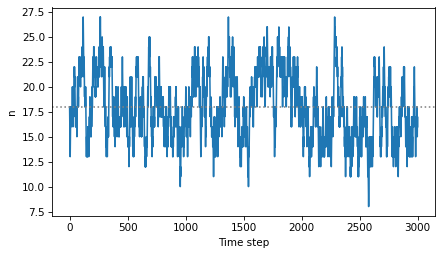

In [15]:
plt.plot(ns)
plt.axhline(mean, ls=':', color='gray')
decorate(xlabel='Time step', ylabel='n')

For a bad device, it takes longer to accumulate enough evidence to overcome the lower prior probability.

In [16]:
n0 = 52
ns = simulate(n0, q2)
mean = np.mean(ns)
mean

53.1569476841053

The critical value of `n` is around 52.

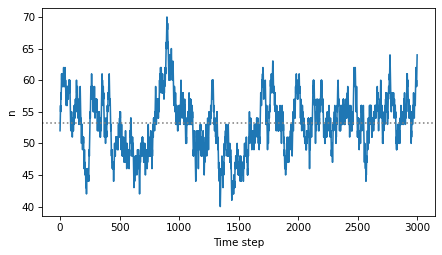

In [17]:
plt.plot(ns)
plt.axhline(mean, ls=':', color='gray')
decorate(xlabel='Time step', ylabel='n')

So that's an answer to the first question. It's not a formula, as OP requested, but if we're given different values of `q1`, `q2`, and the prior probabilities, we can run these simulations to estimate the critical values of `n`.

## Run Until Confident

Now here's a different version of the experiment that runs until one of the posterior probabilities exceeds the threshold.

In [18]:

def run_until_threshold(prior, actual, n=1, threshold=0.95):
    """
    """
    posterior = prior
    for i in range(1, 1001):
        data = generate(n, actual)
        posterior = update(posterior, data)
        for q, p in posterior.items():
            if p >= threshold:
                return i, q

    return -1, np.nan

The return values are the number of time steps, and the conclusion of the experiment, which is the value of `q` whose posterior probability exceeded the threshold.

In [19]:
actual = prior.sample(1)[0]
i, final = run_until_threshold(prior, actual)
actual, i, final

(0.5, 18, 0.5)

The following loop runs this simulated experiment many times and put the results in a `DataFrame`.

In [20]:
res = []
for i in range(1001):
    actual = prior.sample(1)[0]
    i, final = run_until_threshold(prior, actual)
    res.append((actual, i, final))

df = pd.DataFrame(res, columns=['actual', 'steps', 'final'])
df.head()

,actual,steps,final
0,0.5,25,0.5
1,0.7,28,0.7
2,0.5,60,0.5
3,0.5,18,0.5
4,0.5,33,0.5


The average number of steps to reach the given level of confidence is about 25.

In [21]:
df['steps'].mean()

24.857142857142858

And the conclusion is correct about 95% of the time, as promised.

In [22]:
def is_correct(df):
    return (df['actual'] == df['final']).mean()

In [23]:
is_correct(df)

0.9500499500499501

And that's true whether the conclusion is `q1` or `q2`.

In [24]:
is_correct(df.loc[df['final'] == q1])

0.9490683229813665

In [25]:
is_correct(df.loc[df['final'] == q2])

0.9540816326530612

But the number of steps is shorter if the actual value is `q1`, and longer if it's `q2`.

In [26]:
steps1 = df.loc[df['actual'] == q1, 'steps']
steps1.mean()

20.301423027166884

In [27]:
steps2 = df.loc[df['actual'] == q2, 'steps']
steps2.mean()

40.30263157894737

Here's what the distribution of step sizes looks like.

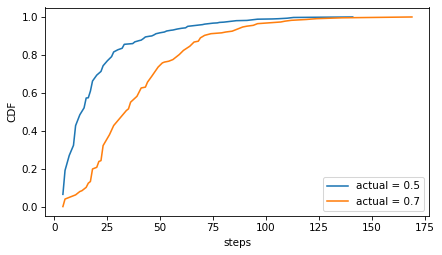

In [28]:
from empiricaldist import Cdf

Cdf.from_seq(steps1).plot(label=f'actual = {q1}')
Cdf.from_seq(steps2).plot(label=f'actual = {q2}')
decorate(ylabel='CDF')

Usually it doesn't take more than 50 steps to reach the threshold, but if you're unlucky, it can take more than 100. 

## Discussion

In classical hypothesis testing, it is a no-no to run an experiment until it reaches a desired level of significance. In fact, under the null hypothesis, [the probability of generating a false positive approaches 100%](https://allendowney.blogspot.com/2011/10/repeated-tests-how-bad-can-it-be.html).

But with this kind of Bayesian update, it's not a problem. The results depend only on the data, not the stopping condition. And the results in this notebook show that the posterior probabilities are calibrated -- that is, if you are 95% sure you have identified a good or defective flipper, you are right 95% of the time.

Although we used Bayes's Theorem to compute the posterior probabilities, I would argue that this is not really an example of Bayesian statistics. Bayes's Theorem is a mathematical law -- you can use it with no obligation to adopt the Bayesian interpretation of probability. In this example, if we choose a flipper at random, the unknown parameter, `q`, is a random quantity with an objectively known distribution. So the analysis we did is valid under even the strictest frequentist interpretation of probability.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)